## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [8]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
from DDQN.trainer import Stats, Round, CustomHockeyMode, train_ddqn_agent
import hockey.hockey_env as h_env


reload(h_env)
reload(ddqn)

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'DDQN.DDQN' from '/home/kivanc/ders/RL/project/RL-Hockey/DDQN/DDQN.py'>

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

### Environment & Agent Initialization

In [10]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

In [11]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-3

agent_player = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [12]:
# For the visualisation of the training progress
stats = Stats()

### Training

In [13]:
rounds = [
    Round(100, agent_opp_weak, CustomHockeyMode.NORMAL),
    Round(200, agent_opp_strong, CustomHockeyMode.NORMAL),
    Round(50, agent_opp_weak, CustomHockeyMode.SHOOTING),
    Round(50, agent_opp_weak, CustomHockeyMode.DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_SHOOTING_DEFENSE),
    Round(100, agent_opp_strong, CustomHockeyMode.RANDOM_ALL),
]

train_ddqn_agent(
    agent_player,
    env,
    max_steps=1000,
    rounds=rounds,
    stats=stats,
    ddqn_iter_fit=64,
    print_freq=100,
    tqdm=tqdm,
    verbose=True
)

Begin round 1 with mode NORMAL for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: -10.75090063681668 | Loss: 0.14552247524261475 | Done in 32 steps
Episode 100 | Return: -35.12476122290462 | Loss: 0.0673157349228859 | Done in 251 steps
Begin round 2 with mode NORMAL for 200 episodes


  0%|          | 0/200 [00:00<?, ?it/s]

Episode 1 | Return: -30.010693724294217 | Loss: 0.07216265797615051 | Done in 251 steps
Episode 101 | Return: -3.281832672524451 | Loss: 0.06546683609485626 | Done in 251 steps
Episode 200 | Return: -10.870550040375221 | Loss: 0.07942257821559906 | Done in 14 steps
Begin round 3 with mode TRAIN_SHOOTING for 50 episodes


  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1 | Return: -18.140726684475744 | Loss: 0.01397184282541275 | Done in 251 steps
Episode 50 | Return: -21.9210666279083 | Loss: 0.07539460062980652 | Done in 211 steps
Begin round 4 with mode TRAIN_DEFENSE for 50 episodes


  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1 | Return: -13.967206198298538 | Loss: 0.015422803349792957 | Done in 251 steps
Episode 50 | Return: 9.593006612547839 | Loss: 0.12159685790538788 | Done in 29 steps
Begin round 5 with mode TRAIN_SHOOTING for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: 1.3206043550857167 | Loss: 0.0059441677294671535 | Done in 209 steps
Episode 100 | Return: -18.1296359984264 | Loss: 0.09239435940980911 | Done in 219 steps
Begin round 6 with mode TRAIN_SHOOTING for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: -13.2298509565349 | Loss: 0.12406089901924133 | Done in 194 steps
Episode 100 | Return: -20.68961011004474 | Loss: 0.03801380470395088 | Done in 140 steps


## Agent Model Saving

In [14]:
STATE_PATH = "./DDQN/models/hockey_mixed_dev/"

reload(ddqn)

agent_player.save_state(STATE_PATH)

## Visualization

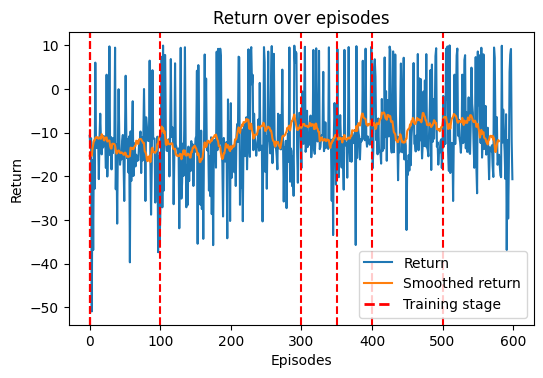

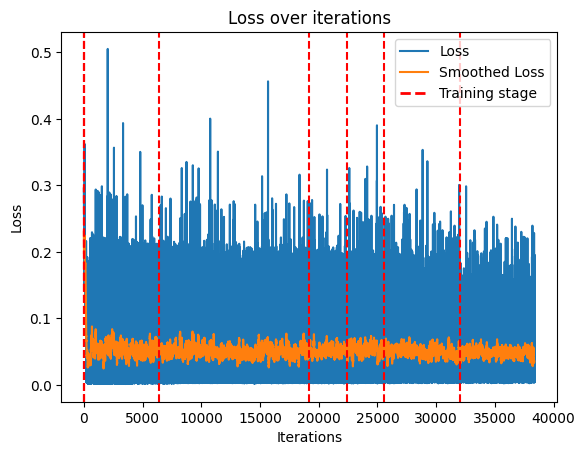

In [15]:
returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 50), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [ ]:
obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_opp = env.obs_agent_two()

done = False
trunc = False
step = 0
while not (done or trunc):
    step += 1
    env.render()
    
    a1_discr = agent_player.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent_opp_strong.act(obs_opp)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_opp = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {step} steps")
        break

Episode done in 250 steps


In [54]:
env.close()